# Facial Emotion Recognition | VGG19 Model


## Library

In [3]:
import math
import numpy as np
import pandas as pd
import random
import os

import cv2
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

2024-03-21 11:01:11.607420: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-21 11:01:11.607522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-21 11:01:11.738149: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [78]:
train_data_dir = "/kaggle/input/emotiondataset/datasets/train"
test_data_dir = "/kaggle/input/emotiondataset/datasets/test"

In [79]:
def collect_data(directory):
    data = []
    labels = []

    total = 0

    for index, label  in enumerate(os.listdir(directory)):

        for image_file in os.listdir(os.path.join(directory, label)):

            img = cv2.imread(os.path.join(os.path.join(directory, label, image_file)))

            data.append(img)
            labels.append(label)

            total += 1

    print(f'Total data saved = {total}')
    return data,labels

In [80]:
final_data = []
final_labels = []

# Getting train_datas
print("Train Datas")

train_data, train_labels = collect_data(train_data_dir)
final_data.extend(train_data)
final_labels.extend(train_labels)

# Getting test_datas
print("Test Datas")

test_data, test_labels = collect_data(test_data_dir)
final_data.extend(test_data)
final_labels.extend(test_labels)


Train Datas
Total data saved = 28709
Test Datas
Total data saved = 7178


In [81]:
combined_list = list(zip(final_data,final_labels))
final_data,final_labels = zip(*combined_list)

In [82]:
data = np.array(final_data)
labels = np.array(final_labels)

In [83]:
labels

array(['surprise', 'surprise', 'surprise', ..., 'happy', 'happy', 'happy'],
      dtype='<U8')

In [84]:
categories = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [85]:
X_train, X_valid, y_train, y_valid = train_test_split(data,
                                                      labels,
                                                      test_size = 0.2)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((28709, 48, 48, 3), (7178, 48, 48, 3), (28709,), (7178,))

In [86]:
from keras.utils import to_categorical

In [87]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_valid = label_encoder.transform(y_valid)

In [88]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = 7

In [89]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [90]:
vgg = tf.keras.applications.VGG19(weights = 'imagenet',
                                  include_top = False,
                                  input_shape = (48, 48, 3))

In [91]:
vgg.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
def build_model(bottom_model, classes):
    x = bottom_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Add a dense output layer with the softmax activation function
    x = Dense(7, activation='softmax')(x)
    
    # Define the model
    model = Model(inputs=bottom_model.input, outputs=x)
    
    # Freeze the VGG19 layers
    for layer in bottom_model.layers:
        layer.trainable = False
    return model

In [93]:
model = build_model(vgg, num_classes)


print(model.summary())

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 20,027,975 (76.40 MB)

 Trainable params: 3,591 (14.03 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

None


In [94]:
train_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.1, zoom_range=0.1)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [95]:
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/emotiondataset/datasets/train',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical')

Found 28709 images belonging to 7 classes.


In [96]:
validation_generator = test_datagen.flow_from_directory(
    '/kaggle/input/emotiondataset/datasets/test',
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical')

Found 7178 images belonging to 7 classes.


In [99]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


callbacks = [reduce_lr,early_stop]

In [100]:
# batch size of 32 performs the best.
batch_size = 32
epochs = 50
steps_per_epoch = np.ceil(len(X_train) / batch_size)


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [101]:
y_train

array([5, 6, 0, ..., 5, 5, 2])

In [103]:
model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    class_weight=class_weight,
    callbacks=[reduce_lr, early_stop])

NameError: name 'validation_steps' is not defined

# Save Logs

In [ ]:
# Create a DataFrame from the history object
history_df = pd.DataFrame(history.history)

# Save the DataFrame to a CSV file
history_df.to_csv('logs/training_history.csv', index=False)

In [ ]:
sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

# plt.savefig('epoch_history_dcnn.png')
plt.show()


# Save Model

In [ ]:
model.save('models/vgg.h5')

# Load Model

In [ ]:
model = tf.keras.models.load_model('models/vgg.h5')

# Metrices

In [ ]:
import numpy as np

# Get predictions from your model
y_pred = model.predict(X_valid)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = label_encoder.transform(y_valid)

In [38]:
from sklearn.metrics import classification_report

report = classification_report(y_valid, y_pred_classes, target_names=categories)
print(report)

              precision    recall  f1-score   support



       angry       0.29      0.53      0.37       978

     disgust       0.00      0.00      0.00       109

        fear       0.24      0.22      0.23       991

       happy       0.76      0.67      0.71      1816

     neutral       0.41      0.41      0.41      1271

         sad       0.50      0.09      0.15      1250

    surprise       0.31      0.55      0.40       763



    accuracy                           0.42      7178

   macro avg       0.36      0.35      0.32      7178

weighted avg       0.46      0.42      0.40      7178




<Axes: >

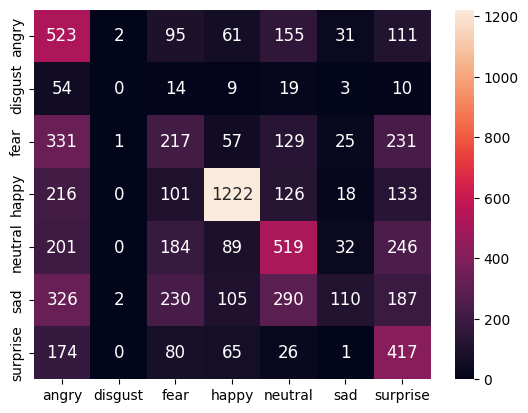

In [50]:
cf_matrix = confusion_matrix(y_valid, y_pred_classes)
cm_array_df = pd.DataFrame(cf_matrix, index=categories, columns=categories)
sns.heatmap(cm_array_df, annot=True, annot_kws={"size": 12},fmt=".0f") 

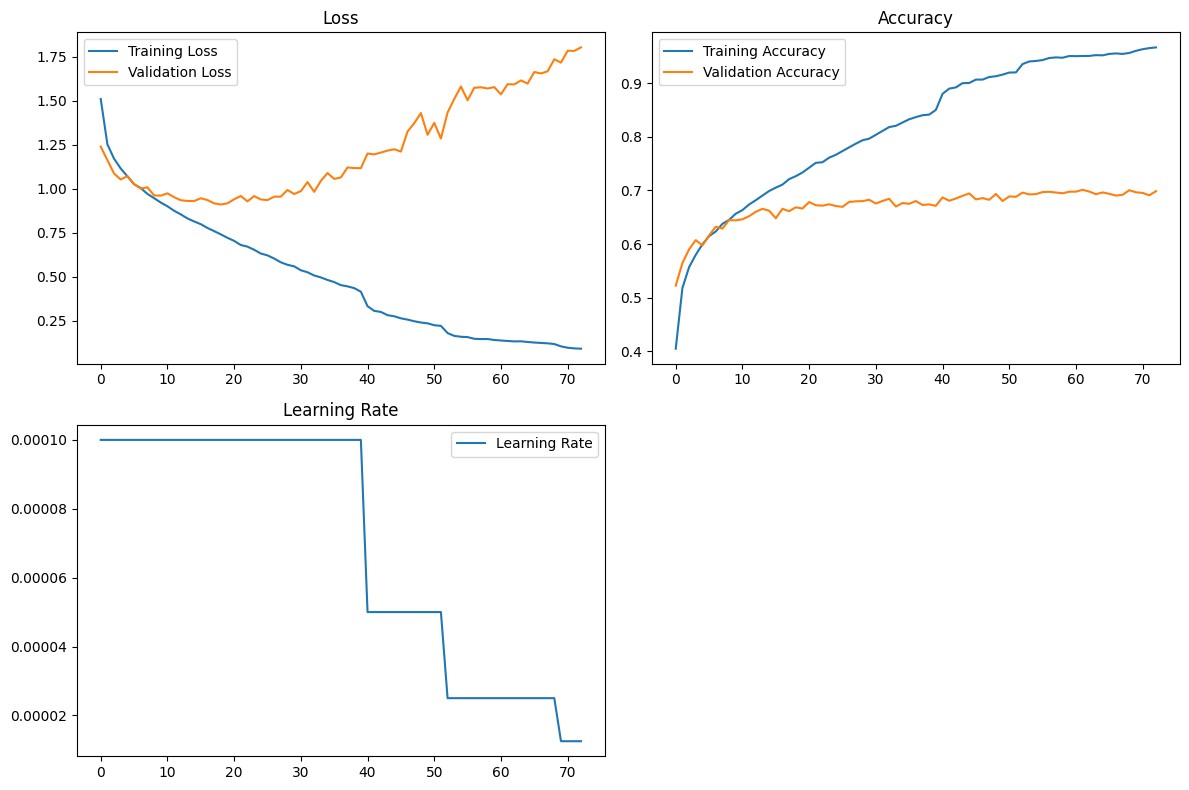

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a DataFrame
history_df = pd.read_csv('training_history_vgg.csv')  # Replace 'your_history.csv' with your actual file name

# Extract relevant columns
train_loss = history_df['loss']
train_accuracy = history_df['accuracy']
val_loss = history_df['val_loss']
val_accuracy = history_df['val_accuracy']
lr = history_df['lr']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot loss
axes[0, 0].plot(history_df.index, train_loss, label='Training Loss')
axes[0, 0].plot(history_df.index, val_loss, label='Validation Loss')
axes[0, 0].set_title('Loss')
axes[0, 0].legend()

# Plot accuracy
axes[0, 1].plot(history_df.index, train_accuracy, label='Training Accuracy')
axes[0, 1].plot(history_df.index, val_accuracy, label='Validation Accuracy')
axes[0, 1].set_title('Accuracy')
axes[0, 1].legend()

# Plot learning rate
axes[1, 0].plot(history_df.index, lr, label='Learning Rate')
axes[1, 0].set_title('Learning Rate')
axes[1, 0].legend()

# Remove the empty subplot
fig.delaxes(axes[1, 1])

# Adjust layout and show plot
plt.tight_layout()
plt.show()
